# Análisis Exploratorio inicial

Exploración de las primeras tres preguntas del proyecto de pronóstico de demanda usando únicamente `pandas` y `matplotlib`.


In [18]:

import pandas as pd 
import matplotlib.pyplot as plt

CSV = "ventas_hiperrealistas.csv"
ProductosAnalisis = ["Leche Entera 1L", "Helado Chocolate Suizo 1L"]
meses = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]

#recorre la lista meses asociando un indice (Ene = 1), en donde label es el mes e idx el numero asociado
NumeroMes = {idx + 1: label for idx, label in enumerate(meses)} 
#trabajaremos con series temporales históricas para extraer tendencias y estacionalidad antes de modelar.


In [19]:

df = pd.read_csv(CSV, parse_dates=["Date"])


columnas = df.columns.tolist() #lista con los encabezados
rango = (df["Date"].min().date(), df["Date"].max().date())
print(f"Primer y último registro: {rango[0]} a {rango[1]}")
#Primeras 5 filas
print("primeras 5 filas")
df.head()


Primer y último registro: 2012-01-01 a 2020-12-31
primeras 5 filas


,TransactionID,Date,ProductID,ProductName,ProductCategory,Quantity,UnitPrice,TotalPrice
0,1,2012-01-01,402,Leche Entera 1L,Lácteos,2,950,1900
1,2,2012-01-01,103,Pan de Molde Blanco,Panadería,1,1800,1800
2,3,2012-01-01,101,Refresco Cola 2L,Bebidas,2,1500,3000
3,4,2012-01-01,402,Leche Entera 1L,Lácteos,1,950,950
4,5,2012-01-01,401,Yogurt Frutilla 125g,Lácteos,3,400,1200


## Pregunta 1
Generar la serie de tiempo de la cantidad total vendida y describir la tendencia y patrones estacionales.

In [20]:

# Series de tiempo: agregamos transacciones a nivel diario (unidades y ventas).

#ordenasmos las ventas diarias, agrupando por fecha y suma de las cantidades vendidas en esa fecha
ventas_diarias = (
    df.groupby(pd.Grouper(key="Date", freq="M"))
      .agg(TotalUnidadesDia=('Quantity', 'sum'),
           TotalVentasDia=('TotalPrice', 'sum'))
      .reset_index()
      .sort_values('Date')
)

# Medias móviles de 30 días en unidades y ventas
#PU30: Promedio unidades a 30 dias
#PV30: Promedio Ventas a 30 dias
ventas_diarias['PU3'] = ventas_diarias['TotalUnidadesDia'].rolling(window=3, min_periods=3).mean().shift(1)
ventas_diarias['PV3'] = ventas_diarias['TotalVentasDia'].rolling(window=3, min_periods=3).mean().shift(1)

#Resumen a grandes rasgos del CSV

resumen_unidades = {
    'Inicio operaciones': ventas_diarias['Date'].min().date(),
    'Final de operaciones': ventas_diarias['Date'].max().date(),
    'Promedio diario (unidades)': round(ventas_diarias['TotalUnidadesDia'].mean(), 0),
    'Máximo diario (unidades)': int(ventas_diarias['TotalUnidadesDia'].max()),
    'Mínimo diario (unidades)': int(ventas_diarias['TotalUnidadesDia'].min()),
}
resumen_ventas = {
    'Promedio diario ($)': round(ventas_diarias['TotalVentasDia'].mean(), 0),
    'Máximo diario ($)': round(ventas_diarias['TotalVentasDia'].max(), 0),
    'Mínimo diario ($)': round(ventas_diarias['TotalVentasDia'].min(), 0),
}

print('Resumen de la serie diaria (unidades):')
for i, valor in resumen_unidades.items():
    print(f'  {i}: {valor}')
print()
print('Resumen de la serie diaria (ventas $):')
for i, valor in resumen_ventas.items():
    print(f'  {i}: {valor}')


Resumen de la serie diaria (unidades):
  Inicio operaciones: 2012-01-31
  Final de operaciones: 2020-12-31
  Promedio diario (unidades): 14594.0
  Máximo diario (unidades): 22392
  Mínimo diario (unidades): 8600

Resumen de la serie diaria (ventas $):
  Promedio diario ($): 31866577.0
  Máximo diario ($): 48489400
  Mínimo diario ($): 19650350


/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_95889/1628066611.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key="Date", freq="M"))


In [21]:
ventas_diarias.head()
ventas_diarias["TotalVentasDia"].sum()

3441590350

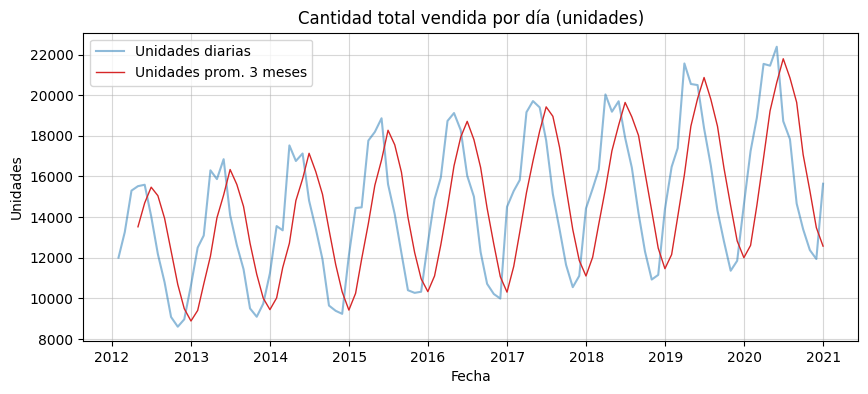

In [24]:
#Grafica Serie de tiempo con método medias moviles a 30 dias
#Unidades vendidas
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ventas_diarias['Date'], ventas_diarias['TotalUnidadesDia'], label='Unidades diarias', alpha=0.5, color='tab:blue')
ax.plot(ventas_diarias['Date'], ventas_diarias['PU3'], label='Unidades prom. 3 meses', linewidth=1, color='tab:red')
ax.set_title('Cantidad total vendida por día (unidades)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades')
ax.legend()
ax.grid(alpha=0.5)
plt.show()


In [23]:
#Grafica Serie de tiempo con método medias moviles a 30 dias
#Ventas en $

ventas_diarias['TotalVentasDia']=ventas_diarias['TotalVentasDia']/1000
ventas_diarias['PV30']=ventas_diarias['PV30']/1000

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ventas_diarias['Date'], ventas_diarias['TotalVentasDia'], label='Ventas diarias ($)', alpha=0.35, color='blue')
ax.plot(ventas_diarias['Date'], ventas_diarias['PV30'], label='Ventas prom. 30d ($)', linewidth=1, color='red')
ax.set_title('Monto total vendido por día (ventas)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Ventas ($)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()


KeyError: 'PV30'

In [ ]:
# Resumen anual para unidades y ventas.

ventas_anuales = (
    ventas_diarias.set_index('Date')[['TotalUnidadesDia', 'TotalVentasDia']]
    .resample('YE')
    .sum()
)


promedio_anual_unidades = ventas_anuales['TotalUnidadesDia'].mean()
promedio_anual_ventas = ventas_anuales['TotalVentasDia'].mean()
print('Unidades y ventas por año:')
print(f"Promedio anual de unidades vendidas: {promedio_anual_unidades}")
print(f"Promedio anual de ventas ($): {promedio_anual_ventas}")
ventas_anuales

Unidades y ventas por año:
Promedio anual de unidades vendidas: 175133.88888888888
Promedio anual de ventas ($): 382398.9277777777


,TotalUnidadesDia,TotalVentasDia
Date,,
2012-12-31,145979,331267.35
2013-12-31,152325,343182.90
2014-12-31,158868,353741.80
2015-12-31,169437,373091.20
2016-12-31,175714,383108.50
2017-12-31,183417,394604.45
2018-12-31,187990,401120.65
2019-12-31,196350,419649.45
2020-12-31,206125,441824.05


In [ ]:

# Promedios mensuales (promedio de todos los enero, febrero, etc.)
resumen_promedios_mensuales = (
    ventas_diarias.set_index('Date')[['TotalUnidadesDia', 'TotalVentasDia']]
    .resample('MS')
    .sum()
    .groupby(lambda fecha: fecha.month)
    .mean()
)
resumen_promedios_mensuales.index = [NumeroMes[idx] for idx in resumen_promedios_mensuales.index]

print('Promedio mensual histórico de unidades y ventas:')
resumen_promedios_mensuales.round(1)


Promedio mensual histórico de unidades y ventas:


,TotalUnidadesDia,TotalVentasDia
Ene,14644.8,32713.7
Feb,15398.8,33590.8
Mar,18663.3,42359.9
Abr,18488.8,38016.1
May,18748.4,41075.2
Jun,16377.0,37438.9
Jul,14813.7,31698.6
Ago,12800.9,26613.0
Sep,11052.6,24111.3
Oct,10306.4,23233.2


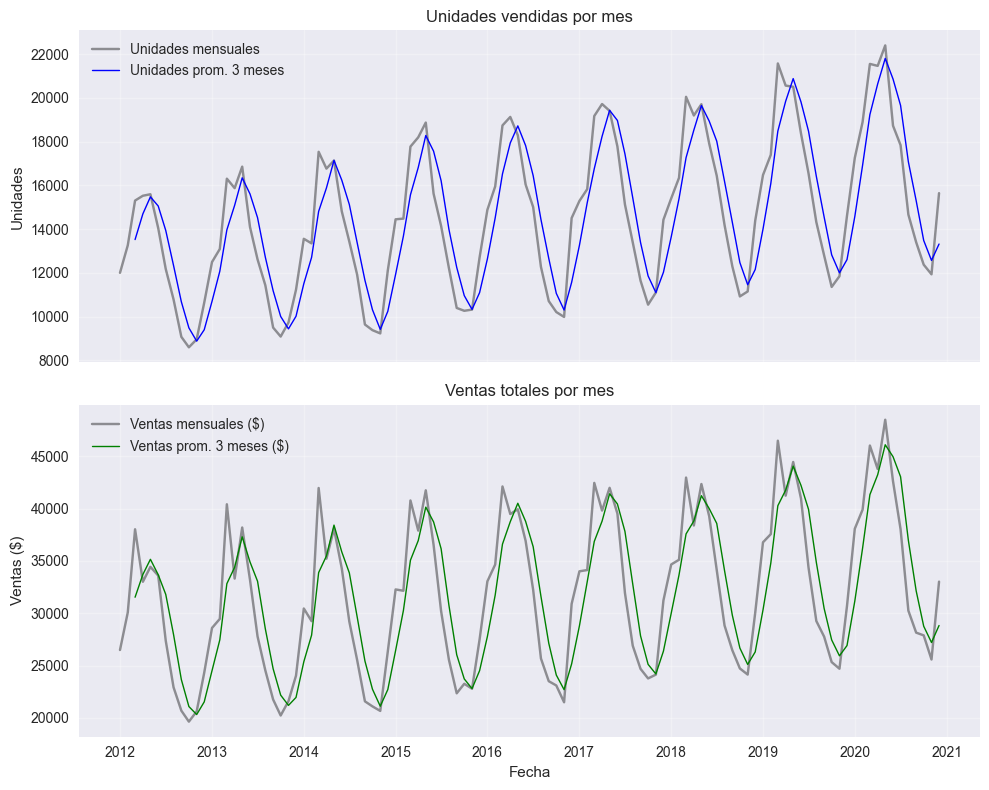

In [ ]:

# Visualización mensual de unidades y ventas con promedio móvil de 3 meses.
ventas_mensuales_full = (
    ventas_diarias.set_index('Date')[['TotalUnidadesDia', 'TotalVentasDia']]
    .resample('MS')
    .sum()
    .assign(
        unidades_prom_3m=lambda df: df['TotalUnidadesDia'].rolling(window=3, min_periods=3).mean(),
        ventas_prom_3m=lambda df: df['TotalVentasDia'].rolling(window=3, min_periods=3).mean(),
    )
)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].plot(ventas_mensuales_full.index, ventas_mensuales_full['TotalUnidadesDia'], label='Unidades mensuales', alpha=0.4, color='black')
axes[0].plot(ventas_mensuales_full.index, ventas_mensuales_full['unidades_prom_3m'], label='Unidades prom. 3 meses', linewidth=1, color='blue')
axes[0].set_ylabel('Unidades')
axes[0].set_title('Unidades vendidas por mes')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(ventas_mensuales_full.index, ventas_mensuales_full['TotalVentasDia'], label='Ventas mensuales ($)', alpha=0.4, color='black')
axes[1].plot(ventas_mensuales_full.index, ventas_mensuales_full['ventas_prom_3m'], label='Ventas prom. 3 meses ($)', linewidth=1, color='green')
axes[1].set_ylabel('Ventas ($)')
axes[1].set_title('Ventas totales por mes')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xlabel('Fecha')

plt.tight_layout()
plt.show()

